# Analyze attributions for test set genes

In [1]:
import numpy as np
import pandas as pd
import anndata
import h5py
from tqdm import tqdm
import bioframe as bf
import os, sys
from plotnine import *

sys.path.append('/code/decima/src/decima')
from grelu.io.genome import read_gtf

%matplotlib inline

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Paths

In [2]:
save_dir="/gstore/data/resbioai/grelu/decima/20240823"
matrix_file = os.path.join(save_dir, "data.h5ad")
h5_file = os.path.join(save_dir, "attr.h5")

## Load test genes

In [3]:
ad = anndata.read_h5ad(matrix_file)
ad = ad[:, ad.var.dataset == "test"].copy()

## Get relative start and end positions for each gene

In [4]:
genes = ad.var.reset_index()
genes['gene'] = ad.var_names
genes['st'] = genes.gene_start - genes.start
genes['en'] = [min(524287, x) for x in genes.gene_end - genes.start]

In [6]:
genes.head()

,index,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,...,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson,ensembl_canonical_tss,gene,st,en
0,VPS37D,chr7,73503991,74028279,+,protein_coding,0.001710,0.679836,5076,73667831,...,0.0,['fold3'],test,ENSG00000176428,0.642895,0.526187,73667831.0,VPS37D,163840,168121
1,PHF10,chr6,169365118,169889406,-,protein_coding,0.000000,3.062159,8620,169703902,...,0.0,['fold3'],test,ENSG00000130024,0.533576,0.465699,169724500.0,PHF10,338784,360448
2,WDR38,chr9,124689577,125213865,+,protein_coding,0.085990,0.207100,1889,124853417,...,0.0,['fold3'],test,ENSG00000136918,0.450509,0.063697,124853460.0,WDR38,163840,168313
3,LRRTM4,chr2,77232871,77757159,-,protein_coding,0.088598,2.153711,4128,76747719,...,0.0,['fold3'],test,ENSG00000176204,0.946549,0.661515,77522376.0,LRRTM4,-485152,360448
4,FIGLA,chr2,70430195,70954483,-,protein_coding,0.112137,0.064763,1747,70777310,...,0.0,['fold3'],test,ENSG00000183733,0.100247,0.203060,70790643.0,FIGLA,347115,360448


## Load CREs

In [6]:
# Encode CREs
#!wget https://downloads.wenglab.org/V3/GRCh38-cCREs.bed

--2025-12-16 23:58:09--  https://downloads.wenglab.org/V3/GRCh38-cCREs.bed
Resolving downloads.wenglab.org (downloads.wenglab.org)... 146.189.25.27
Connecting to downloads.wenglab.org (downloads.wenglab.org)|146.189.25.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63732631 (61M) [application/octet-stream]
Saving to: ‘GRCh38-cCREs.bed’

GRCh38-cCREs.bed    100%[===================>]  60.78M  16.7MB/s    in 4.2s    

2025-12-16 23:58:13 (14.6 MB/s) - ‘GRCh38-cCREs.bed’ saved [63732631/63732631]



In [7]:
cre = pd.read_table('GRCh38-cCREs.bed', header=None, usecols=(0, 1, 2, 5))
cre.columns=['chrom', 'start', 'end', 'class']

## Load exon annotations

In [8]:
gtf = read_gtf(
    '/gstore/data/resbioai/grelu/decima/refdata-gex-GRCh38-2020-A/genes/genes.gtf',
    features=['exon'])
gtf = gtf[gtf.gene_name.isin(ad.var_names)]

00:02:54 | WARNING | Could not find 'genes.annotation.bed(.gz)' in directory /gstore/data/resbioai/grelu/decima/refdata-gex-GRCh38-2020-A/genes. Methods using this file won't work!


In [9]:
gtf.head()

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
138735,chr1,120723949,120724250,NBPF26,HAVANA,exon,.,+,.,"gene_id ""ENSG00000273136""; gene_version ""7""; t..."
138736,chr1,120763636,120763709,NBPF26,HAVANA,exon,.,+,.,"gene_id ""ENSG00000273136""; gene_version ""7""; t..."
138737,chr1,120784974,120785233,NBPF26,HAVANA,exon,.,+,.,"gene_id ""ENSG00000273136""; gene_version ""7""; t..."
138738,chr1,120793161,120793496,NBPF26,HAVANA,exon,.,+,.,"gene_id ""ENSG00000273136""; gene_version ""7""; t..."
138739,chr1,120802613,120802695,NBPF26,HAVANA,exon,.,+,.,"gene_id ""ENSG00000273136""; gene_version ""7""; t..."


## Drop genes for which we have no exon annotations

In [10]:
genes = genes[genes.gene.isin(gtf.gene_name)]
len(genes)

1807

## Read attributions

In [11]:
attrs = {}
with h5py.File(h5_file, 'r') as f:
    for gene in ad.var_names:
        attr = np.array(f[gene])
        if ad.var.strand[gene]=='-':
            attr = attr[::-1]
        attrs[gene] = np.abs(attr)

## Overlap annotations with gene intervals

In [12]:
cre_overlap = bf.overlap(genes, cre, how='inner')
cre_overlap['st'] = cre_overlap.start_ - cre_overlap.start
cre_overlap['en'] = cre_overlap.end_ - cre_overlap.start
cre_overlap['dist'] = np.abs(np.vstack([cre_overlap.start - cre_overlap.gene_start, cre_overlap.start - cre_overlap.gene_end])).min(0)

## Annotate CREs by their distance to the gene

In [13]:
cre_overlap.loc[cre_overlap.dist < 100, 'dist_class'] = '0-100'
cre_overlap.loc[(cre_overlap.dist >= 100) & (cre_overlap.dist < 1000), 'dist_class'] = '100-1kb'
cre_overlap.loc[(cre_overlap.dist >= 1000) & (cre_overlap.dist < 10000), 'dist_class'] ='1-10kb'
cre_overlap.loc[(cre_overlap.dist >= 10000) & (cre_overlap.dist < 100000), 'dist_class'] ='10-100kb'
cre_overlap.loc[cre_overlap.dist >= 100000, 'dist_class'] ='>100kb'

## Annotate each gene with its exons and CREs

In [14]:
annot = dict()
for gene in tqdm(ad.var_names):
    exons = gtf[(gtf.gene_name==gene) & (gtf.start >= ad.var.start[gene]) & (gtf.end <= ad.var.end[gene])].copy()
    exons['st'] = exons['start'] - ad.var.start[gene]
    exons['en'] = exons['end'] - ad.var.start[gene]
    annot[gene] = {'exons':exons}
    annot[gene]['cre'] = cre_overlap[cre_overlap.gene==gene]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1811/1811 [01:16<00:00, 23.77it/s]


## Compute mean attributions in different classes of elements

In [ ]:
genes = genes.iloc[:, :24]
promoter_window = 100
junction_window = 10

for row in tqdm(genes.itertuples()):
    
    exons = annot[row.gene]['exons']
    cres = annot[row.gene]['cre']
    attr = attrs[row.gene]
    
    in_gene = np.array([False]*524288)
    in_promoter = np.array([False]*524288)
    in_exons = np.array([False]*524288)
    in_introns = np.array([False]*524288)
    in_junctions = np.array([False]*524288)
    in_cre = np.array([False]*524288)
    out_1k = np.array([False]*524288)
    out_1k_10k = np.array([False]*524288)
    out_10k_100k = np.array([False]*524288)
    out_100k = np.array([False]*524288)

    # select bases in gene/ promoter / exons / junctions / CREs
    in_gene[row.st: row.en] = True
    if row.strand=='+':
        in_promoter[row.st-promoter_window: row.st+promoter_window] = True
    else:
        in_promoter[row.en-promoter_window: row.en+promoter_window] = True
    
    for exon in exons.itertuples():
        in_exons[exon.st:exon.en] = True
        in_junctions[exon.st - junction_window: exon.st+junction_window] = True
        in_junctions[exon.en - junction_window: exon.en+junction_window] = True

    if len(cres) > 0:
        for cre in cres.itertuples():
            in_cre[cre.st:cre.en] = True

    # Select outer CREs by distance
    out_1k[row.st-1000:row.st] = True
    out_1k[row.en:row.en+1000] = True
    out_1k_10k[row.st-10000:row.st-1000] = True
    out_1k_10k[row.en+1000:row.en+10000] = True
    out_10k_100k[row.st-100000:row.st-10000] = True
    out_10k_100k[row.en+10000:row.en+100000] = True
    out_100k[:row.st-100000] = True
    out_100k[row.en+100000:] = True

    # Compute mean attribution over each annotation
    genes.loc[genes.gene==row.gene, 'Promoter'] = attr[in_promoter].mean()
    genes.loc[genes.gene==row.gene, 'Exons'] = attr[in_exons].mean()
    genes.loc[genes.gene==row.gene, 'Introns'] = attr[in_gene & (~in_exons)].mean()
    genes.loc[genes.gene==row.gene, 'Exon/Intron junctions'] = attr[in_junctions].mean()
    genes.loc[genes.gene==row.gene, 'Intronic CREs'] = attr[in_gene & (~in_exons) & in_cre].mean()
    genes.loc[genes.gene==row.gene, 'Outer CREs'] = attr[(~in_gene) & in_cre].mean()
    genes.loc[genes.gene==row.gene, 'Outer non-CREs'] = attr[(~in_gene) & (~in_cre)].mean()
    
    genes.loc[genes.gene==row.gene, '1k (CREs)'] = attr[out_1k & in_cre].mean()
    genes.loc[genes.gene==row.gene, '1k (Other)'] = attr[out_1k & (~in_cre)].mean()
    genes.loc[genes.gene==row.gene, '1k-10k (CREs)'] = attr[out_1k_10k & in_cre].mean()
    genes.loc[genes.gene==row.gene, '1k-10k (Other)'] = attr[out_1k_10k & (~in_cre)].mean()
    genes.loc[genes.gene==row.gene, '10k-100k (CREs)'] = attr[out_10k_100k & in_cre].mean()
    genes.loc[genes.gene==row.gene, '10k-100k (Other)'] = attr[out_10k_100k & (~in_cre)].mean()
    genes.loc[genes.gene==row.gene, '>=100k (CREs)'] = attr[out_100k & in_cre].mean()
    genes.loc[genes.gene==row.gene, '>=100k (Other)'] = attr[out_100k & (~in_cre)].mean()

24it [00:07,  3.35it/s]/tmp/ipykernel_7353/1734501347.py:51: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_7353/1734501347.py:53: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
30it [00:08,  3.36it/s]/tmp/ipykernel_7353/1734501347.py:53: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
31it [00:09,  3.36it/s]/tmp/ipykernel_7353/1734501347.py:51: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
/tmp/ipykernel_7353/1734501347.py:53: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.11/site-packages/numpy/_core/_methods.py:138: Run

In [17]:
genes.head()

,index,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,...,Outer CREs,Outer non-CREs,1k (CREs),1k (Other),1k-10k (CREs),1k-10k (Other),10k-100k (CREs),10k-100k (Other),>=100k (CREs),>=100k (Other)
0,VPS37D,chr7,73503991,74028279,+,protein_coding,0.001710,0.679836,5076,73667831,...,0.000343,0.000137,0.007121,0.001731,0.001290,0.000529,0.000459,0.000195,0.000179,0.000072
1,PHF10,chr6,169365118,169889406,-,protein_coding,0.000000,3.062159,8620,169703902,...,0.000315,0.000117,0.001789,0.001274,0.000987,0.000310,0.000326,0.000170,0.000211,0.000070
2,WDR38,chr9,124689577,125213865,+,protein_coding,0.085990,0.207100,1889,124853417,...,0.000577,0.000105,0.009838,0.001825,0.001290,0.000523,0.000544,0.000176,0.000120,0.000048
3,LRRTM4,chr2,77232871,77757159,-,protein_coding,0.088598,2.153711,4128,76747719,...,0.001868,0.000290,0.006726,0.000600,0.001717,0.000358,0.002040,0.000309,0.000495,0.000227
4,FIGLA,chr2,70430195,70954483,-,protein_coding,0.112137,0.064763,1747,70777310,...,0.000229,0.000079,0.012076,0.001514,0.001208,0.000306,0.000316,0.000105,0.000103,0.000040


## Visualize attributions in the gene/promoter

1680


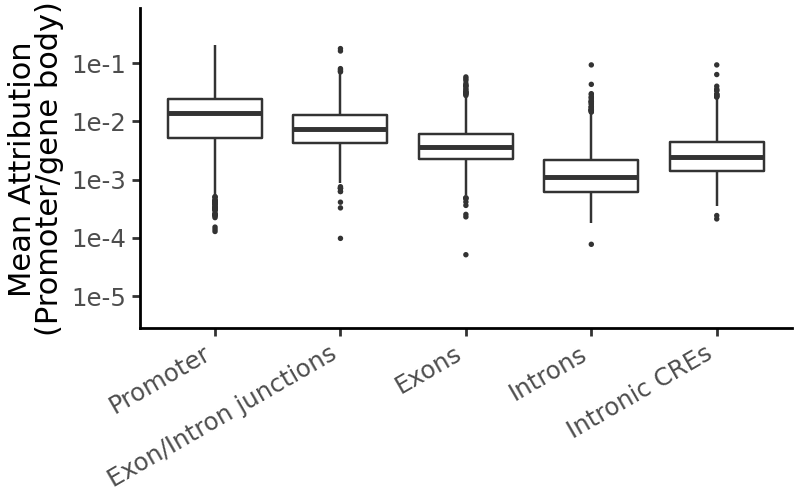

In [24]:
df = genes[['Promoter', 'Exon/Intron junctions', 'Exons', 'Introns', 'Intronic CREs']].dropna().copy()
print(len(df))

df = df.melt()
df.variable = pd.Categorical(df.variable, categories=[
    'Promoter', 'Exon/Intron junctions', 'Exons', 'Introns', 'Intronic CREs'
])
(
    ggplot(df, aes(x='variable', y='value'))
    +geom_boxplot(outlier_size=.1) + theme_classic() + theme(figure_size=(4, 2.5))
    + scale_y_log10(limits = (5e-6, .5)) + ylab("    Mean Attribution\n(Promoter/gene body)") 
    + theme(axis_title_x=element_blank())
    +theme(axis_text_x=element_text(rotation=30, hjust=1))
)

## Compare attributions inside/outside CREs per distance range

In [25]:
df = genes[['1k (Other)', '1k (CREs)', '1k-10k (Other)', '1k-10k (CREs)',
    '10k-100k (Other)', '10k-100k (CREs)', '>=100k (Other)', '>=100k (CREs)']].dropna().copy()
df = df.rename(columns = {
    '1k (Other)':'<1kb (Other)', '1k (CREs)':'<1kb (CREs)',
    '1k-10k (Other)':'1kb-10kb (Other)', '1k-10k (CREs)': '1kb-10kb (CREs)',
    '10k-100k (Other)':'10kb-100kb (Other)', '10k-100k (CREs)': '10kb-100kb (CREs)',
    '>=100k (Other)':'>=100kb (Other)', '>=100k (CREs)':'>=100kb (CREs)'
})
print(len(df))
df = df.melt()
df['Distance'] = [x.split(' ')[0] for x in df.variable]
df.loc[df.variable.str.endswith('CREs)'), 'in CRE'] = True
df.loc[~df.variable.str.endswith('CREs)'), 'in CRE'] = False
df.Distance = pd.Categorical(df.Distance, categories=[
    '<1kb', '1kb-10kb', '10kb-100kb', '>=100kb'])

1683


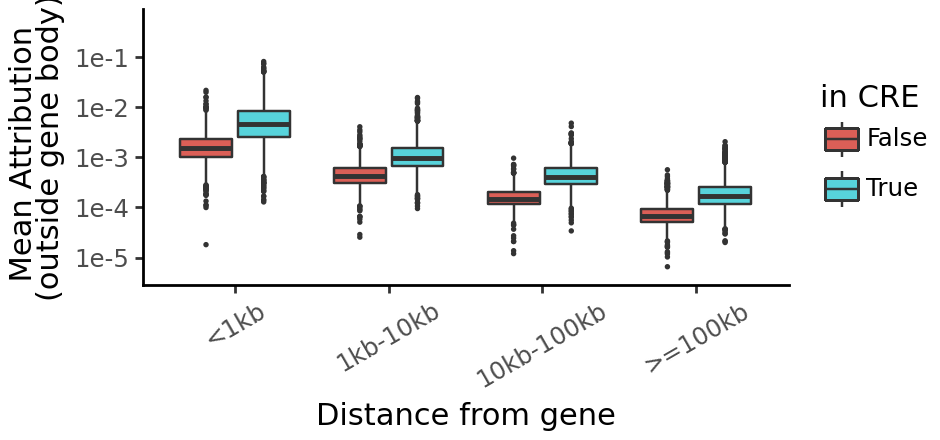

In [26]:
(
    ggplot(df, aes(x='Distance', fill='in CRE', y='value'))
    +geom_boxplot(outlier_size=.1) + theme_classic() + theme(figure_size=(4.7, 2.2))
    + scale_y_log10(limits = (5e-6, .5))
    + ylab("  Mean Attribution\n(outside gene body)") + xlab("Distance from gene")
    +theme(axis_text_x=element_text(rotation=30, hjust=.5))
)